#1. Import Basic Libraries

In [ ]:
# ========== 1. Import Required Libraries ==========

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_curve, roc_auc_score

#2. Set Visualization Style

In [ ]:
# ========== 2. Set Visualixzation Style ==========
sns.set(style="whitegrid")

#3. Load the Dataset from CSV file

In [ ]:
# ========== 3. Load Dataset ==========
df = pd.read_csv("KaggleV2-May-2016.csv")
print("Dataset Loaded. Shape:", df.shape)

Dataset Loaded. Shape: (110527, 14)


#4. Data Preprocessing

In [ ]:
# ========== 4. Data Preprocessing ==========

# Check missing values
print("\nMissing Values:", df.isnull().sum().sum())

# Convert date columns to datetime
df['ScheduledDay'] = pd.to_datetime(df['ScheduledDay'])
df['AppointmentDay'] = pd.to_datetime(df['AppointmentDay'])

# Rename columns
df.rename(columns={
    'No-show': 'No_show',
    'Hipertension': 'Hypertension',
    'Handcap': 'Handicap'
}, inplace=True)

# Check the dataset
print(df.info())


Missing Values: 0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype              
---  ------          --------------   -----              
 0   PatientId       110527 non-null  float64            
 1   AppointmentID   110527 non-null  int64              
 2   Gender          110527 non-null  object             
 3   ScheduledDay    110527 non-null  datetime64[ns, UTC]
 4   AppointmentDay  110527 non-null  datetime64[ns, UTC]
 5   Age             110527 non-null  int64              
 6   Neighbourhood   110527 non-null  object             
 7   Scholarship     110527 non-null  int64              
 8   Hypertension    110527 non-null  int64              
 9   Diabetes        110527 non-null  int64              
 10  Alcoholism      110527 non-null  int64              
 11  Handicap        110527 non-null  int64              
 12  SMS_received    110527 non-null  int64              


#5. Feature Engineering for ML Models

In [ ]:
# Extract the hour of the day when the appointment was scheduled
df['ScheduledHour'] = df['ScheduledDay'].dt.hour

In [ ]:
# Calculate the waiting time in days between scheduling and the appointment
df['WaitingTimeDays'] = (df['AppointmentDay'] - df['ScheduledDay']).dt.days

In [ ]:
# Create age groups
df['AgeGroup'] = pd.cut(df['Age'], bins=[0, 18, 35, 50, 65, 100], labels=['0-18', '19-35', '36-50', '51-65', '66+'])

In [ ]:
# Create a new column for the total number of chronic conditions
df['TotalChronicConditions'] = df[['Hypertension', 'Diabetes', 'Alcoholism', 'Handicap']].sum(axis=1)

In [ ]:
# Create a new column to indicate if the appointment is on a weekend
df['IsWeekend'] = df['AppointmentDay'].dt.dayofweek.isin([5, 6]).astype(int)

In [ ]:
# Create a new feature for SMS reminders received
df['ReceivedSMS'] = df['SMS_received'].map({1: 'Yes', 0: 'No'})

In [ ]:
# Extract the day of the week for the appointment
df['AppointmentDayOfWeek'] = df['AppointmentDay'].dt.day_name()

In [ ]:
# Create a feature for the number of days until the next appointment (if applicable)
df['DaysUntilNextAppointment'] = df.groupby('PatientId')['AppointmentDay'].diff().dt.days

In [ ]:
# Convert 'No_show' column to binary (1 for Yes, 0 for No)
df['No_show'] = df['No_show'].map({'Yes': 1, 'No': 0})

# Create a feature for the number of previous no-shows by the patient
df['PreviousNoShows'] = df.groupby('PatientId')['No_show'].cumsum() - df['No_show']

In [ ]:
# Create a feature for the total number of appointments per patient
df['TotalAppointments'] = df.groupby('PatientId')['AppointmentID'].transform('count')

In [ ]:
# Encode categorical variables as needed for modeling
df = pd.get_dummies(df, columns=['Neighbourhood', 'AgeGroup', 'ReceivedSMS', 'AppointmentDayOfWeek'], drop_first=True)

In [ ]:
# Drop irrelevant columns
df = df.drop(columns=['PatientId', 'AppointmentID', 'ScheduledDay', 'AppointmentDay'])

In [ ]:
# Display the first few rows of the dataset after feature engineering
print(df.head())

  Gender  Age  Scholarship  Hypertension  Diabetes  Alcoholism  Handicap  \
0      F   62            0             1         0           0         0   
1      M   56            0             0         0           0         0   
2      F   62            0             0         0           0         0   
3      F    8            0             0         0           0         0   
4      F   56            0             1         1           0         0   

   SMS_received  No_show  ScheduledHour  ...  AgeGroup_19-35  AgeGroup_36-50  \
0             0        0             18  ...           False           False   
1             0        0             16  ...           False           False   
2             0        0             16  ...           False           False   
3             0        0             17  ...           False           False   
4             0        0             16  ...           False           False   

   AgeGroup_51-65  AgeGroup_66+  ReceivedSMS_Yes  AppointmentD

#6. Machine learning Prediction Model

#6.1 Dataset spliting

In [ ]:
# Define features (X) and target (y)
X = df.drop(columns=['No_show'])  # Features
y = df['No_show']  # Target variable

# Convert categorical variables to numeric using one-hot encoding
X = pd.get_dummies(X, drop_first=True)

# Impute missing values with the mean (or median/mode)
imputer = SimpleImputer(strategy='mean')
X = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

# Split the dataset (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Print shapes of the resulting datasets
print("Training set shape:", X_train.shape)
print("Testing set shape:", X_test.shape)

Training set shape: (88421, 105)
Testing set shape: (22106, 105)


#6.2 Model Evaluation function

In [ ]:
# Function to evaluate models
def evaluate_model(model, X_train, X_test, y_train, y_test):
    # Train the model
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)

    # Predict probabilities for ROC curve
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)[:, 1]
    elif hasattr(model, "decision_function"):
        y_proba = model.decision_function(X_test)
    else:
        print("Model does not support probability prediction. Skipping ROC curve.")
        y_proba = None

    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    class_report = classification_report(y_test, y_pred)

    # Print results
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print("Confusion Matrix:\n", conf_matrix)
    print("Classification Report:\n", class_report)

    # Plot Confusion Matrix
    plt.figure(figsize=(6, 5))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Predicted: 0', 'Predicted: 1'],
                yticklabels=['Actual: 0', 'Actual: 1'])
    plt.title("Confusion Matrix")
    plt.ylabel("Actual")
    plt.xlabel("Predicted")
    plt.tight_layout()
    plt.show()

     # Plot ROC Curve
    if y_proba is not None:
        fpr, tpr, thresholds = roc_curve(y_test, y_proba)
        auc_score = roc_auc_score(y_test, y_proba)

        print(f"\nROC AUC Score: {auc_score:.4f}")

        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, label=f"AUC = {auc_score:.4f}", color='darkorange')
        plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title("ROC Curve")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    return model

#6.3 Model Initialization

In [ ]:
# Initialize models
log_reg = LogisticRegression(random_state=42, max_iter=1000)
rf = RandomForestClassifier(random_state=42, n_estimators=100)
xgb = XGBClassifier(random_state=42, n_estimators=100, learning_rate=0.1)

#6.4 Logistic Regression Model Evaluation

Logistic Regression Results:
Accuracy: 0.7963
Precision: 0.4371
Recall: 0.0311
F1-Score: 0.0581
Confusion Matrix:
 [[17463   179]
 [ 4325   139]]
Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.99      0.89     17642
           1       0.44      0.03      0.06      4464

    accuracy                           0.80     22106
   macro avg       0.62      0.51      0.47     22106
weighted avg       0.73      0.80      0.72     22106



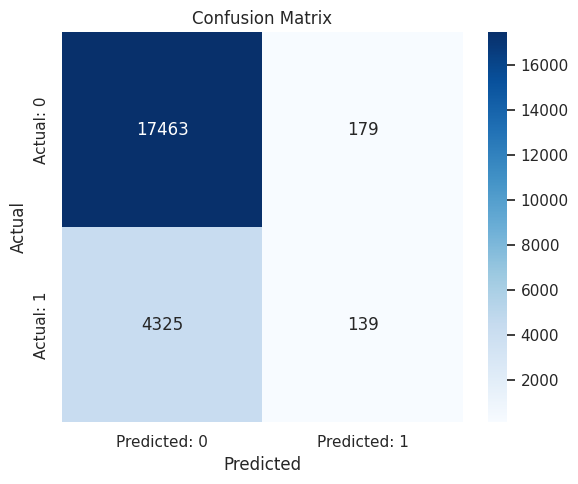


ROC AUC Score: 0.6835


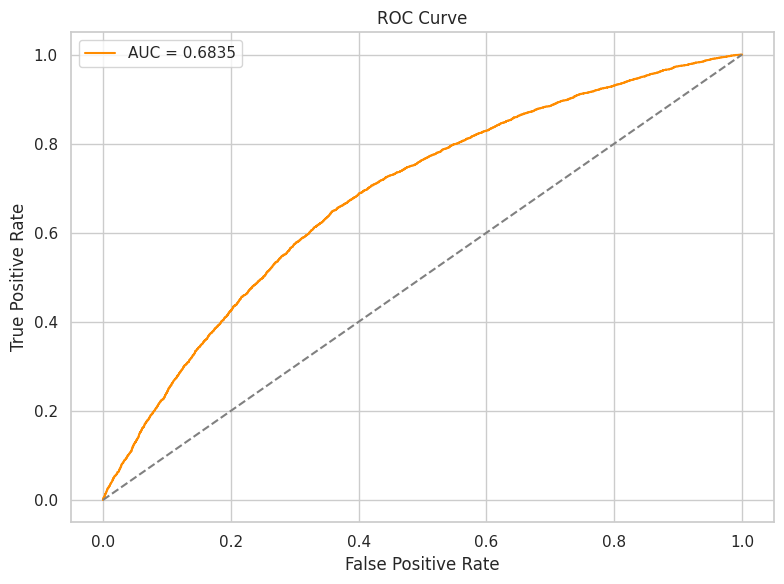

In [ ]:
# Evaluate Logistic Regression
print("Logistic Regression Results:")
log_reg = evaluate_model(log_reg, X_train, X_test, y_train, y_test)

#6.5 Random Forest Model Evaluation

Random Forest Results:
Accuracy: 0.8011
Precision: 0.5337
Recall: 0.1190
F1-Score: 0.1945
Confusion Matrix:
 [[17178   464]
 [ 3933   531]]
Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.97      0.89     17642
           1       0.53      0.12      0.19      4464

    accuracy                           0.80     22106
   macro avg       0.67      0.55      0.54     22106
weighted avg       0.76      0.80      0.75     22106



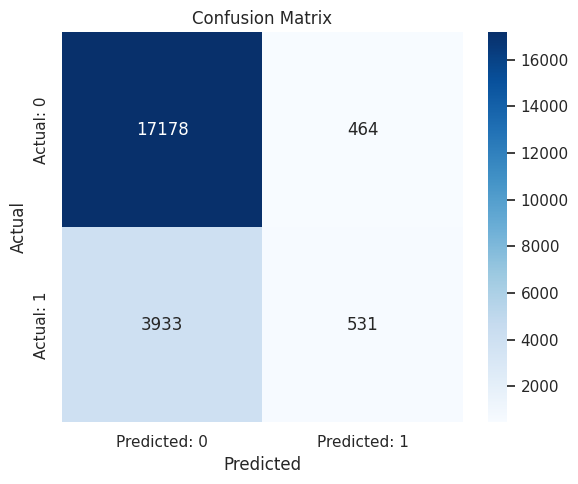


ROC AUC Score: 0.7469


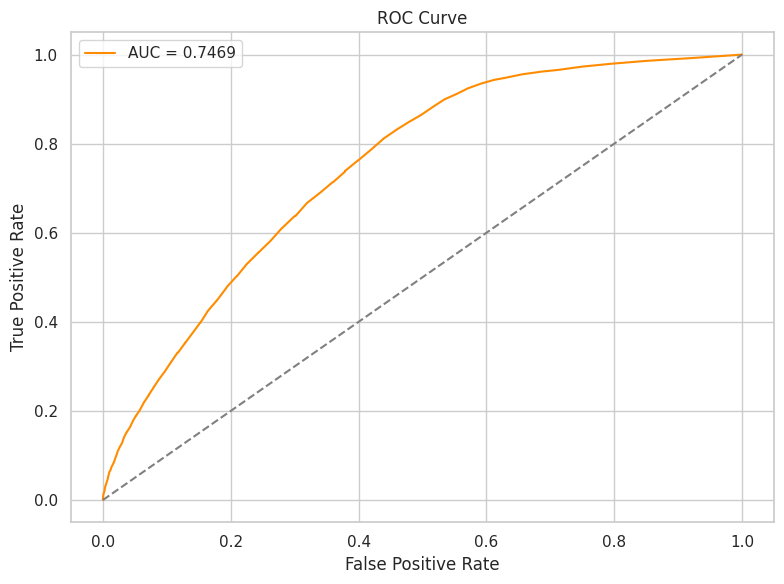

In [ ]:
# Evaluate Random Forest
print("Random Forest Results:")
rf = evaluate_model(rf, X_train, X_test, y_train, y_test)

#6.6 XGBoost Model Evaluation

XGBoost Results:
Accuracy: 0.8040
Precision: 0.6238
Recall: 0.0739
F1-Score: 0.1322
Confusion Matrix:
 [[17443   199]
 [ 4134   330]]
Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.99      0.89     17642
           1       0.62      0.07      0.13      4464

    accuracy                           0.80     22106
   macro avg       0.72      0.53      0.51     22106
weighted avg       0.77      0.80      0.74     22106



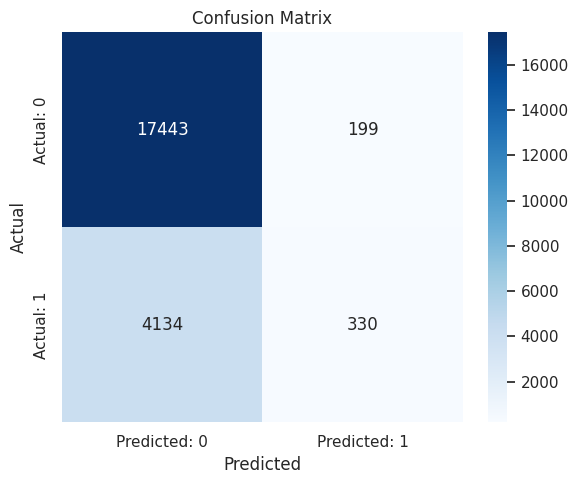


ROC AUC Score: 0.7585


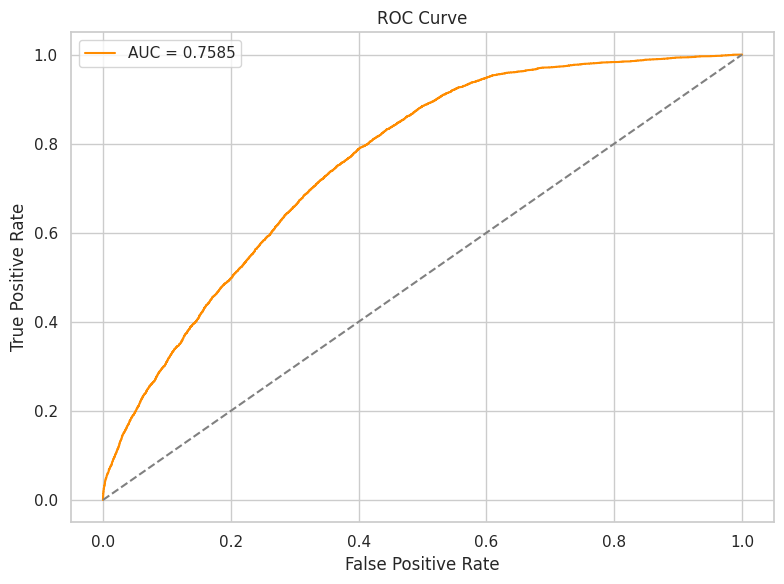

In [ ]:
# Evaluate XGBoost
print("XGBoost Results:")
xgb = evaluate_model(xgb, X_train, X_test, y_train, y_test)

#7. Hyperparameter Tuning

In [ ]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# Define the parameter grid for each model
param_grid_log_reg = {
    'C': [0.01, 0.1, 1, 10, 100],  # Regularization strength
    'penalty': ['l1', 'l2'],  # Type of regularization
    'solver': ['liblinear']  # Solver for optimization
}

param_grid_rf = {
    'n_estimators': [50, 100, 200],  # Number of trees in the forest
    'max_depth': [None, 10, 20, 30],  # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],  # Minimum samples required to split a node
    'min_samples_leaf': [1, 2, 4]  # Minimum samples required at each leaf node
}

param_grid_xgb = {
    'n_estimators': [50, 100, 200],  # Number of boosting rounds
    'learning_rate': [0.01, 0.1, 0.2],  # Learning rate
    'max_depth': [3, 5, 7],  # Maximum depth of a tree
    'subsample': [0.8, 0.9, 1.0],  # Fraction of samples used for training
    'colsample_bytree': [0.8, 0.9, 1.0]  # Fraction of features used for training
}

# Perform GridSearchCV for Logistic Regression
print("Tuning Logistic Regression...")
grid_log_reg = GridSearchCV(LogisticRegression(random_state=42, max_iter=1000), param_grid_log_reg, cv=5, scoring='accuracy')
grid_log_reg.fit(X_train, y_train)
print("Best parameters for Logistic Regression:", grid_log_reg.best_params_)
print("Best cross-validation score for Logistic Regression:", grid_log_reg.best_score_)

# Perform RandomizedSearchCV for Random Forest
print("\nTuning Random Forest...")
random_rf = RandomizedSearchCV(RandomForestClassifier(random_state=42), param_grid_rf, n_iter=10, cv=5, scoring='accuracy', random_state=42)
random_rf.fit(X_train, y_train)
print("Best parameters for Random Forest:", random_rf.best_params_)
print("Best cross-validation score for Random Forest:", random_rf.best_score_)

# Perform RandomizedSearchCV for XGBoost
print("\nTuning XGBoost...")
random_xgb = RandomizedSearchCV(XGBClassifier(random_state=42), param_grid_xgb, n_iter=10, cv=5, scoring='accuracy', random_state=42)
random_xgb.fit(X_train, y_train)
print("Best parameters for XGBoost:", random_xgb.best_params_)
print("Best cross-validation score for XGBoost:", random_xgb.best_score_)

Tuning Logistic Regression...
Best parameters for Logistic Regression: {'C': 0.01, 'penalty': 'l2', 'solver': 'liblinear'}
Best cross-validation score for Logistic Regression: 0.797016545995137

Tuning Random Forest...
Best parameters for Random Forest: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 30}
Best cross-validation score for Random Forest: 0.805114155286183

Tuning XGBoost...
Best parameters for XGBoost: {'subsample': 1.0, 'n_estimators': 200, 'max_depth': 7, 'learning_rate': 0.1, 'colsample_bytree': 1.0}
Best cross-validation score for XGBoost: 0.8050689339190438


# Hyperparameter Tuning Insights

#1. Logistic Regression
Best Parameters:
*   C: 0.01 (regularization strength)
*   Penalty: L2 (ridge regularization)
*   Solver: liblinear (optimization algorithm)

Best Cross-Validation Score: 0.7970

Insights:

*   The model performs best with strong regularization (C=0.01), indicating that the dataset might have some noise or less important features that need to be penalized.
*   The choice of L2 penalty suggests that the model benefits from shrinking all coefficients uniformly rather than performing feature selection (which L1 would do).
*   The cross-validation score of 79.7% is decent but lower than the other models, suggesting that Logistic Regression might not be the best fit for this dataset.

#2. Random Forest
Best Parameters:
*   n_estimators: 200 (number of trees)
*   max_depth: 30 (maximum depth of tree)
*   min_samples_split: 2 (minimum samples required to spilt node)
*   min_samples_leaf: 2 (minimum samples required at each leaf node)

Best Cross-Validation Score: 0.8051

Insights:

*   The model performs best with 200 trees and tree depth of 30, indicating that the dataset benefits from complex trees that can capture intricate patterns.
*   The low values for min_samples_split and min_samples_leaf suggest that the model can handle smaller subsets of data without overfitting, likely due to the ensemble nature of Random Forest.
*   The cross-validation score of 80.51% is the highest among the three models, suggesting that Random Forest is the best-performing model for this dataset.

#3. XGBoost
Best Parameters:
*   n_estimators: 200 (number of boosting rounds)
*   max_depth: 7 (maximum depth of tree)
*   learning_rate: 0.1 (step size shrinkage)
*   subsample: 1.0 (fraction of samples used for training)
*   colsample_bytree: 1.0 (fraction of features used for training)

Best Cross-Validation Score: 0.8050

Insights:

*  The model performs best with 200 boosting rounds and a moderate learning rate of 0.1, indicating that the dataset benefits from a balance between learning speed and model complexity.
*   The tree depth of 7 suggests that the dataset does not require very deep trees to capture patterns, which helps prevent overfitting.
*   The subsample ratio of 1.0 indicates that the model performs well when using 100% of the data for each tree.
*  The cross-validation score of 80.50% is slightly better than Logistic Regression, indicating that XGBoost is a better fit for this dataset.



#8. Feature Importance Function

In [ ]:
import textwrap

# Function to plot feature importance and print top N features
def plot_feature_importance(model, feature_names, title, top_n=20):
    importance = model.feature_importances_
    indices = np.argsort(importance)[::-1]  # Sort indices in descending order

    # Plot only the top N features
    plt.figure(figsize=(12, 8))
    plt.bar(range(top_n), importance[indices][:top_n], align="center")

    # Wrap long feature names and rotate labels
    wrapped_labels = [textwrap.fill(label, width=10) for label in feature_names[indices][:top_n]]
    plt.xticks(range(top_n), wrapped_labels, rotation=45, ha='right')

    plt.xlabel("Feature")
    plt.ylabel("Importance")
    plt.title(title)
    plt.tight_layout()  # Adjust layout to prevent overlapping
    plt.show()

    # Print top N features and their importance scores
    print(f"\nTop {top_n} Most Important Features for {title}:")
    for i in range(top_n):
        print(f"{i + 1}. {feature_names[indices[i]]}: {importance[indices[i]]:.4f}")

# Get feature names after one-hot encoding
feature_names = np.array(X.columns)

#8.1 Random Forest Feature Importance

Random Forest Feature Importance:


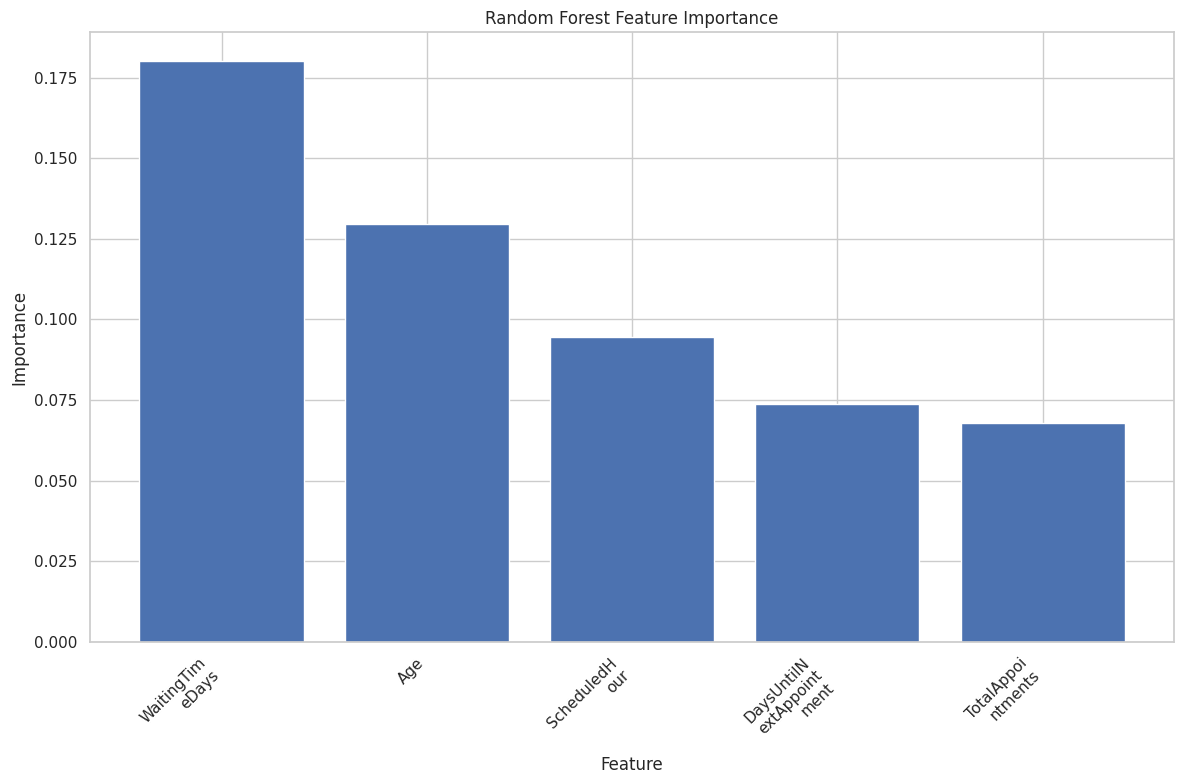


Top 5 Most Important Features for Random Forest Feature Importance:
1. WaitingTimeDays: 0.1800
2. Age: 0.1295
3. ScheduledHour: 0.0945
4. DaysUntilNextAppointment: 0.0738
5. TotalAppointments: 0.0679


In [ ]:
# Plot feature importance for Random Forest and print top 5 features
print("Random Forest Feature Importance:")
plot_feature_importance(rf, feature_names, "Random Forest Feature Importance", top_n=5)

#8.2 XGBoost Feature Importance


XGBoost Feature Importance:


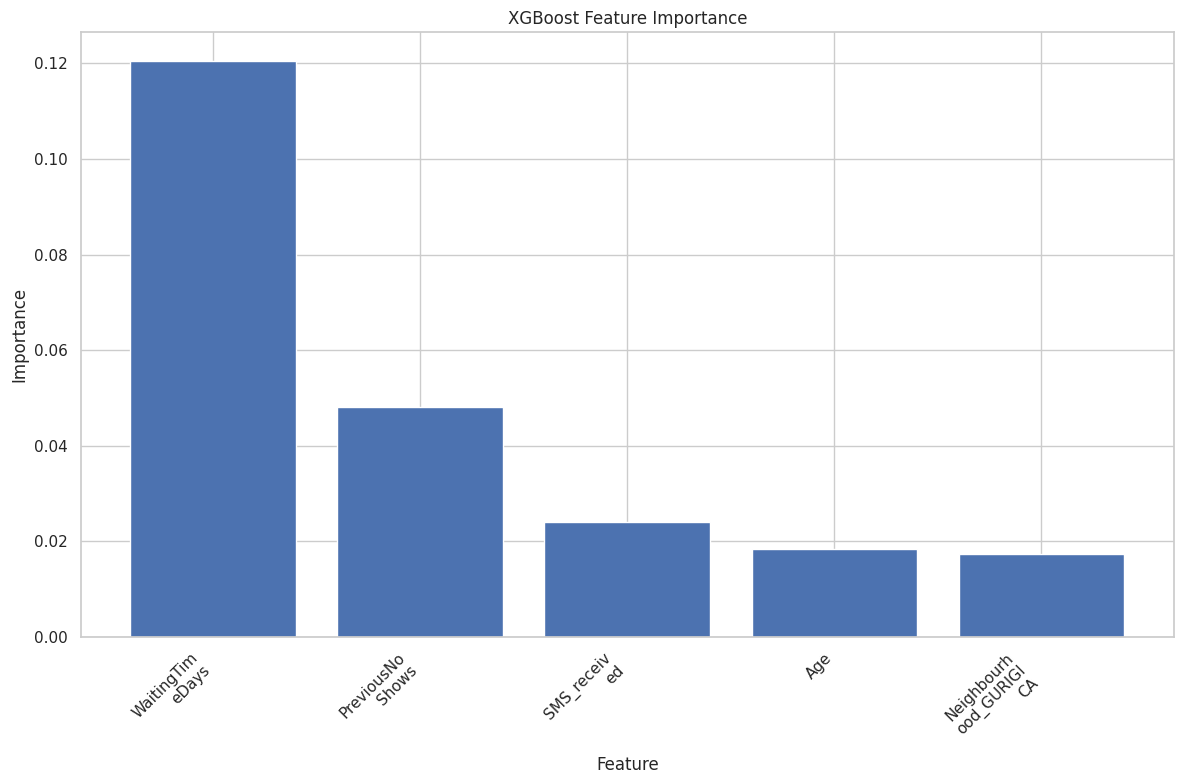


Top 5 Most Important Features for XGBoost Feature Importance:
1. WaitingTimeDays: 0.1205
2. PreviousNoShows: 0.0480
3. SMS_received: 0.0240
4. Age: 0.0185
5. Neighbourhood_GURIGICA: 0.0174


In [ ]:
# Plot feature importance for XGBoost and print top 5 features
print("\nXGBoost Feature Importance:")
plot_feature_importance(xgb, feature_names, "XGBoost Feature Importance", top_n=5)

#9. Save Cleaned and Modified Dataset

In [ ]:
df.to_csv('cleaned_and_modified_data.csv', index=False)

#10. Summary -

Model Performance :-
*   Random forest achieves the highest cross-validation score (80.51%), followed closely by XGBoost (80.50%), and then Logistic Regression (79.70%).
*   This indicates that tree-based models (Random Forest and XGBoost) are better suited for this dataset compared to Logistic Regression.

Recommendations :-
*   Use Random Forest as the primary model for this dataset, as it achieves the highest cross-validation score.
*   Consider feature importance analysis to further refine the model by removing less important features.



